### protein fdr 0.01  and psm fdr 0.01

In [1]:
%load_ext rpy2.ipython

/home/qinchunyuan/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [65]:
# preprocess out_msstats.csv

import pandas as pd

def remove_decoy(Pro):
    if "CONTAMINANT" in Pro or "DECOY_" in Pro:
        t = []
        for p in Pro.split(";"):
            if "CONTAMINANT" in p or "DECOY_" in p:
                pass
            else:
                t.append(p)
        return ";".join(t)
    else:
        return Pro
    
data = pd.read_csv("/home/qinchunyuan/proteomicsTMT-1/PXD003772ResultV3/proteomics_tmt//out_msstats.csv", sep=",")
data['ProteinName'] = data.apply(lambda x: remove_decoy(x.ProteinName), axis=1)

requried1 = data['Reference'].map(lambda x : 'TMT6_1' in x)
requried2 = data['Reference'].map(lambda x : 'TMT6_2' in x)
tmt1_quantified_proteins = set(data[requried1]['ProteinName'].tolist())

tmt2_quantified_proteins = set(data[requried2]['ProteinName'].tolist())

data.to_csv("/home/qinchunyuan/tmt_testdata/PXD003772/analysis/out_msstats_pre.csv", index=False, sep=",")
data[requried1].to_csv("/home/qinchunyuan/tmt_testdata/PXD003772/analysis/tmt1_out_msstats_pre.csv", index=False, sep=",")
data[requried2].to_csv("/home/qinchunyuan/tmt_testdata/PXD003772/analysis/tmt2_out_msstats_pre.csv", index=False, sep=",")

In [66]:
%%R -w 1600 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
data_folder = '/home/qinchunyuan/tmt_testdata/PXD003772/analysis'
setwd(data_folder)
openms_output = './out_msstats_pre.csv'

raw.om <- read.csv(openms_output, header = TRUE, sep = ',')

input.om <- OpenMStoMSstatsTMTFormat(raw.om)

head(input.om)

INFO  [2021-09-08 11:00:32] ** Raw data from OpenMS imported successfully.
INFO  [2021-09-08 11:00:32] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-09-08 11:00:32] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-09-08 11:00:32] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-09-08 11:00:32] ** Shared peptides are removed.
INFO  [2021-09-08 11:00:32] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-08 11:00:37] ** PSMs have been aggregated to peptide ions.
INFO  [2021-09-08 11:00:37] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-08 11:00:37] ** Fractionation handled.
INFO  [2021-

### Protein summarization, normalization and visualization¶

INFO  [2021-09-08 12:36:50] ** MSstatsTMT - proteinSummarization function
INFO  [2021-09-08 12:36:50] Summarizing for Run : 1_1_1 ( 1  of  2 )
  |======================================================================| 100%
INFO  [2021-09-08 12:36:52] Summarizing for Run : 2_2_1 ( 2  of  2 )
  |======================================================================| 100%
INFO  [2021-09-08 12:36:56] ** Protein-level summarization done by MSstats.


R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


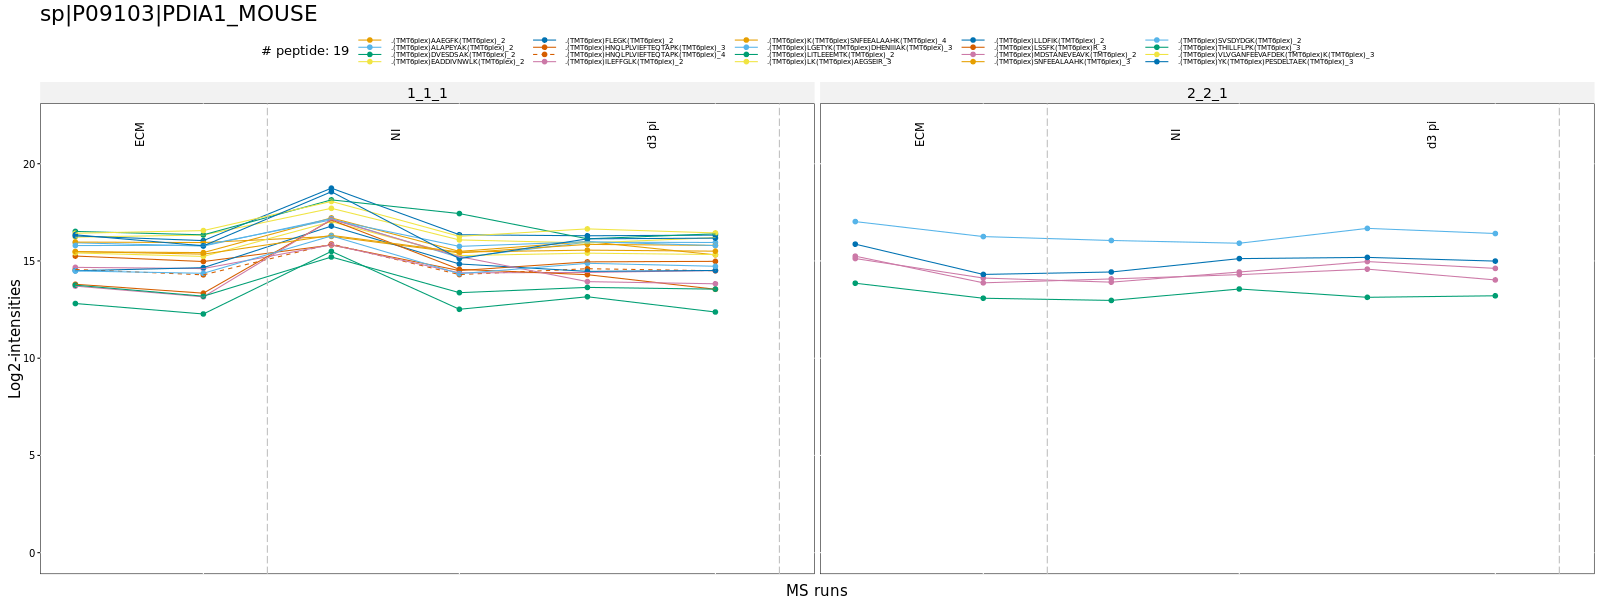

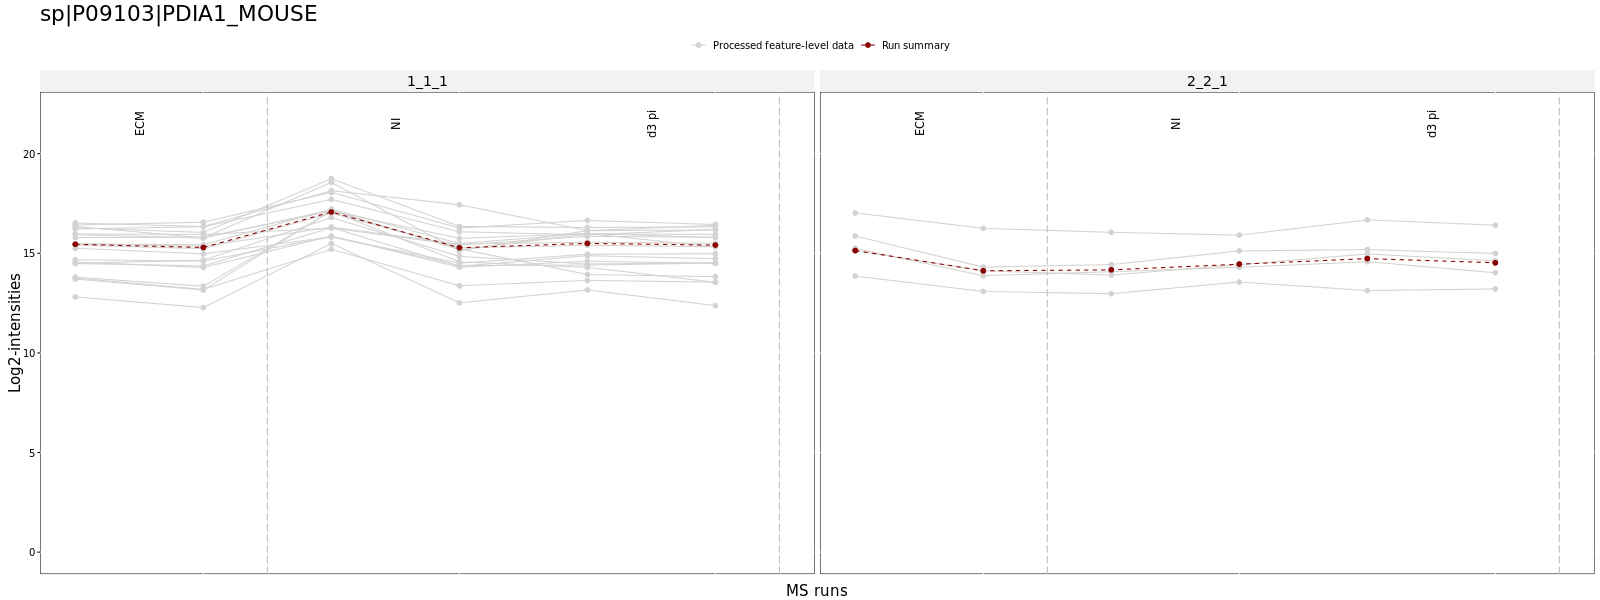

In [67]:
%%R -w 1600 -h 600

protein_expression = './protein_expression.csv'

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=FALSE,
                                      remove_norm_channel = FALSE,
                                      remove_empty_channel = TRUE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|P09103|PDIA1_MOUSE',
                     width = 25, # adjust the figure width 
                     height = 12,
                     address=FALSE)

TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]

write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)

R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



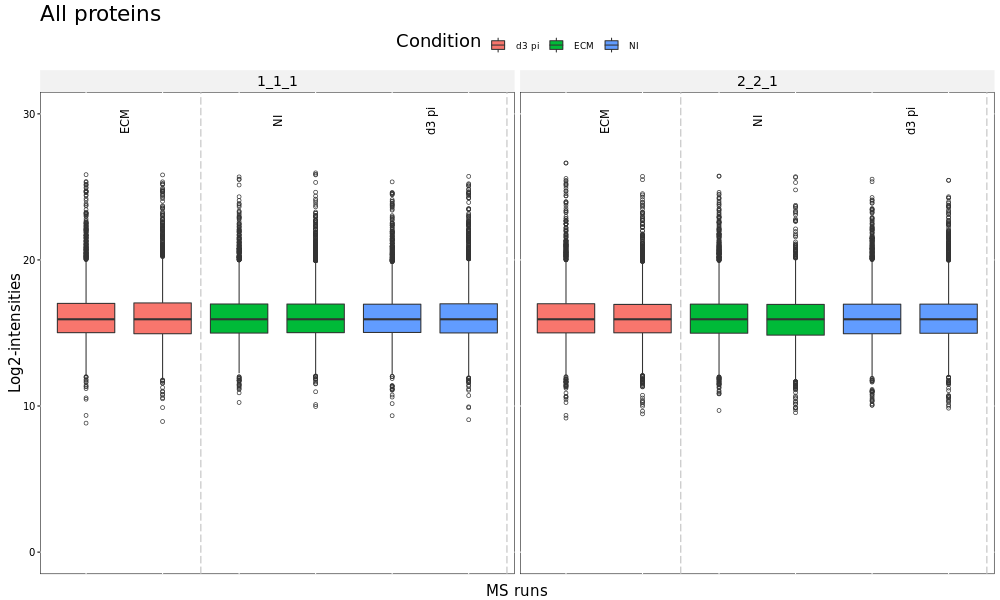

In [68]:
%%R -w 1000 -h 600

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)
## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 25, # adjust the figure width
                     height = 12,
                     address = FALSE)

### Tests for significant changes in protein abundance across conditions

In [69]:
%%R

# Check the conditions in the protein level data
levels(quant_om.msstats$ProteinLevelData$Condition)

[1] "d3 pi" "ECM"   "NI"   


In [70]:
%%R -w 1000 -h 600

TMT_Comp<-matrix(c(0, -1, 1, 1, 1, 0, -1, 0, -1), nrow=3)
row.names(TMT_Comp)<-c("ECM vs NI", "ECM vs d3 pi", "d3 pi vs NI")
colnames(TMT_Comp) = c("d3 pi","ECM", "NI")


TMT_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = TMT_Comp, moderated = TRUE)

head(TMT_Comp.pairwise$ComparisonResult)

INFO  [2021-09-08 12:37:25] Model fitting for 370 proteins.
  |======================================================================| 100%
INFO  [2021-09-08 12:37:36] Testing for 370 proteins:
  |======================================================================| 100%
                 Protein        Label      log2FC        SE       DF     pvalue
1: sp|A6X935|ITIH4_MOUSE    ECM vs NI -0.07974688 0.1762419 12.36014 0.65875871
2: sp|A6X935|ITIH4_MOUSE ECM vs d3 pi  0.01126845 0.1762419 12.36014 0.95004248
3: sp|A6X935|ITIH4_MOUSE  d3 pi vs NI -0.09101534 0.1762419 12.36014 0.61467336
4:  sp|E9PV24|FIBA_MOUSE    ECM vs NI -0.61096923 0.2627155 12.36014 0.03780167
5:  sp|E9PV24|FIBA_MOUSE ECM vs d3 pi  0.05722737 0.2627155 12.36014 0.83111623
6:  sp|E9PV24|FIBA_MOUSE  d3 pi vs NI -0.66819659 0.2627155 12.36014 0.02528839
   adj.pvalue issue
1: 0.73860825    NA
2: 0.97114589    NA
3: 0.97932839    NA
4: 0.09097793    NA
5: 0.89653937    NA
6: 0.97932839    NA


### Visualization ECM vs NI Condition, ECM vs d3 pi Condition and d3 pi vs NI Condition

#### According to the volcano map, it can be seen that the most significant differential expressed proteins are very similar to the orginal

In [71]:
%%R

TMT_Comp = TMT_Comp.pairwise$ComparisonResult
write.table(TMT_Comp,"TMT_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

                 Protein         Label    log2FC    pvalue  -Log10(p-value)  \
0  sp|A6X935|ITIH4_MOUSE     ECM vs NI -0.079747  0.658759         0.181274   
1  sp|A6X935|ITIH4_MOUSE  ECM vs d3 pi  0.011268  0.950042         0.022257   
2  sp|A6X935|ITIH4_MOUSE   d3 pi vs NI -0.091015  0.614673         0.211356   
3   sp|E9PV24|FIBA_MOUSE     ECM vs NI -0.610969  0.037802         1.422489   
4   sp|E9PV24|FIBA_MOUSE  ECM vs d3 pi  0.057227  0.831116         0.080338   

     group  
0  dimgrey  
1  dimgrey  
2  dimgrey  
3    black  
4  dimgrey  


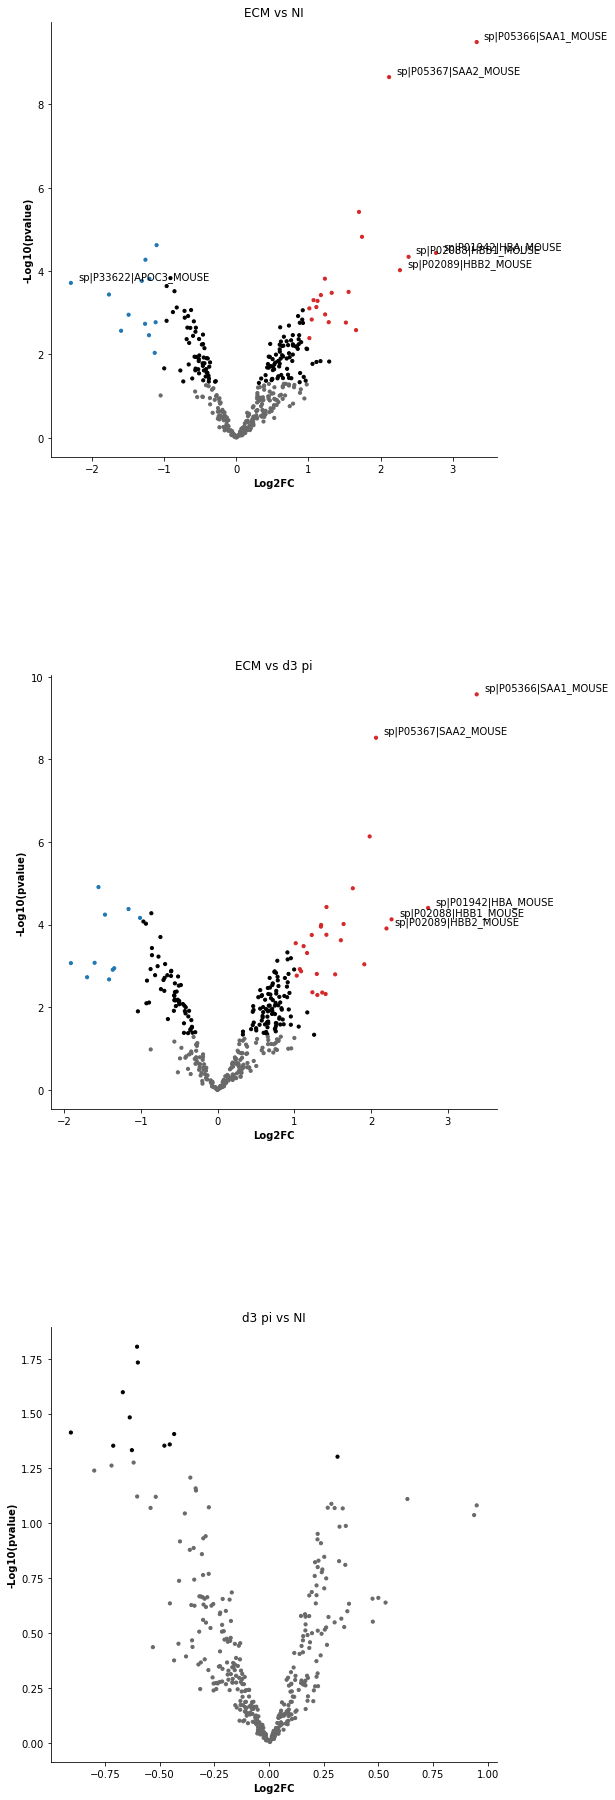

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

result = pd.read_csv('/home/qinchunyuan/tmt_testdata/PXD003772/analysis/TMT_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.01),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.01),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)

    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 2)].iterrows():
        ax.annotate(row['Protein'], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
    i += 1
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()


### Calculate the Overlaping

#### We quantified more proteins, and almost all of the quantified proteins in the original paper are in our results

<AxesSubplot:title={'center':'Quantified Protein in the Whole Experiment'}>

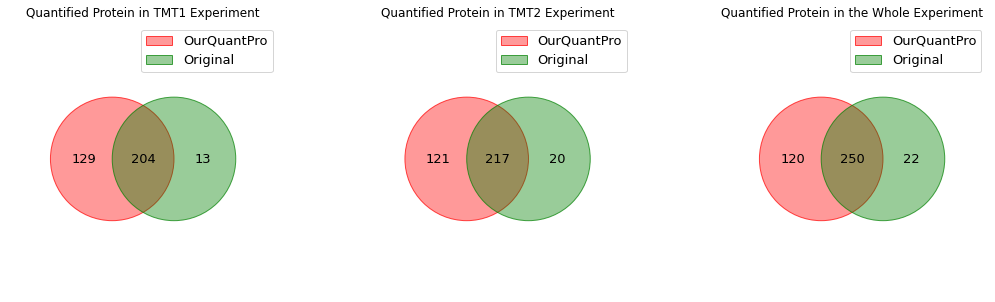

In [74]:
from venn import venn
from matplotlib import pyplot as plt

#  quantified proteins in the TMT1 experiment
_, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
axs[0].set_title("Quantified Protein in TMT1 Experiment")
tmt1_data = pd.read_excel("/home/qinchunyuan/tmt_testdata/PXD003772/analysis/srep37871-s3.xls", sheet_name="TMT6-1 Libra Quant Details", header=1)
tmt1_quantified_proteins = set(map(lambda x : x.split('|')[-1],tmt1_quantified_proteins))
venn({'OurQuantPro': tmt1_quantified_proteins, 'Original': set(tmt1_data['ID'])},cmap=['r', 'g'],figsize=(5, 10), ax=axs[0])


#  quantified proteins in the TMT2 experiment
axs[1].set_title("Quantified Protein in TMT2 Experiment")
tmt2_data = pd.read_excel("/home/qinchunyuan/tmt_testdata/PXD003772/analysis/srep37871-s3.xls", sheet_name="TMT6-2 Libra Quant Details", header=1)
tmt2_quantified_proteins = set(map(lambda x : x.split('|')[-1],tmt2_quantified_proteins))
venn({'OurQuantPro': tmt2_quantified_proteins, 'Original': set(tmt2_data['ID'])}, cmap=['r', 'g'], figsize=(5, 10), ax=axs[1])

axs[2].set_title("Quantified Protein in the Whole Experiment")
AllQuantPro = tmt1_quantified_proteins.union(tmt2_quantified_proteins)
venn({'OurQuantPro': AllQuantPro, 'Original': set(tmt1_data['ID']).union(set(tmt2_data['ID']))}, cmap=['r', 'g'], figsize=(5, 10), ax=axs[2])


##### Calculate the DEP in TMT1 experiment

In [76]:
%%R -w 1000 -h 600

raw.om <- read.csv('./tmt1_out_msstats_pre.csv', header = TRUE, sep = ',')
input.om <- OpenMStoMSstatsTMTFormat(raw.om)
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=FALSE,
                                      remove_norm_channel = FALSE,
                                      remove_empty_channel = TRUE)

TMT1_Comp<-matrix(c(0, -1, 1, 1, 1, 0, -1, 0, -1), nrow=3)
row.names(TMT1_Comp)<-c("ECM vs NI", "ECM vs d3 pi", "d3 pi vs NI")
colnames(TMT1_Comp) = c("d3 pi","ECM", "NI")


TMT1_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = TMT1_Comp, moderated = TRUE)
levels(quant_om.msstats$ProteinLevelData$Condition)

TMT1_Comp = TMT1_Comp.pairwise$ComparisonResult
write.table(TMT1_Comp,"TMT1_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")


INFO  [2021-09-08 12:53:47] ** Raw data from OpenMS imported successfully.
INFO  [2021-09-08 12:53:47] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-09-08 12:53:47] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-09-08 12:53:47] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-09-08 12:53:47] ** Shared peptides are removed.
INFO  [2021-09-08 12:53:47] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-08 12:53:50] ** PSMs have been aggregated to peptide ions.
INFO  [2021-09-08 12:53:50] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-08 12:53:50] ** Fractionation handled.
INFO  [2021-

##### Calculate the DEP in the TMT2 experiment

In [77]:
%%R -w 1000 -h 600

raw.om <- read.csv('./tmt2_out_msstats_pre.csv', header = TRUE, sep = ',')
input.om <- OpenMStoMSstatsTMTFormat(raw.om)
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=FALSE,
                                      remove_norm_channel = FALSE,
                                      remove_empty_channel = TRUE)

TMT2_Comp<-matrix(c(0, -1, 1, 1, 1, 0, -1, 0, -1), nrow=3)
row.names(TMT2_Comp)<-c("ECM vs NI", "ECM vs d3 pi", "d3 pi vs NI")
colnames(TMT2_Comp) = c("d3 pi","ECM", "NI")


TMT2_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = TMT2_Comp, moderated = TRUE)
levels(quant_om.msstats$ProteinLevelData$Condition)

TMT2_Comp = TMT2_Comp.pairwise$ComparisonResult
write.table(TMT2_Comp,"TMT2_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")


INFO  [2021-09-08 12:54:26] ** Raw data from OpenMS imported successfully.
INFO  [2021-09-08 12:54:26] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-09-08 12:54:26] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-09-08 12:54:26] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-09-08 12:54:26] ** Shared peptides are removed.
INFO  [2021-09-08 12:54:26] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-08 12:54:28] ** PSMs have been aggregated to peptide ions.
INFO  [2021-09-08 12:54:28] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-09-08 12:54:28] ** Fractionation handled.
INFO  [2021-

<AxesSubplot:title={'center':'DEP in the TMT2 Experiment'}>

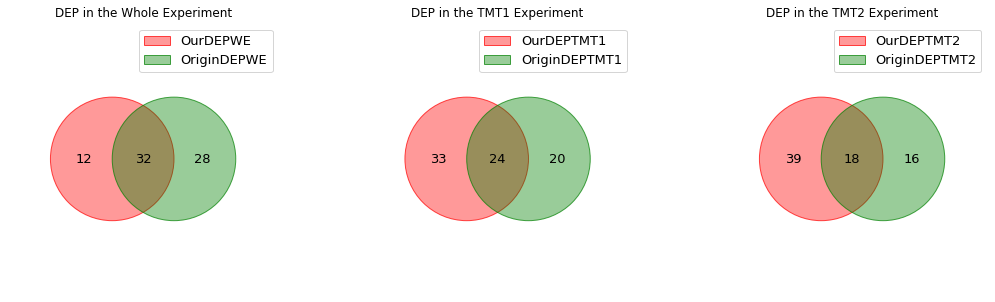

In [7]:
import pandas as pd
import numpy as np
from venn import venn

TMT1Result = pd.read_csv('/home/qinchunyuan/tmt_testdata/PXD003772/analysis/TMT1_Comp_result.csv', sep=',')
TMT1Result = TMT1Result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
TMT1Result["-Log10(p-value)"] = -np.log10(TMT1Result['pvalue'])
#分组为up, normal, down
TMT1Result['group'] = 'black'
TMT1Result.loc[(TMT1Result['log2FC'] > 1)&(TMT1Result['pvalue'] < 0.01),'group'] = 'tab:red' 
TMT1Result.loc[(TMT1Result['log2FC'] < -1)&(TMT1Result['pvalue'] < 0.01),'group'] = 'tab:blue'
TMT1Result.loc[TMT1Result['pvalue'] >= 0.05,'group'] = 'dimgrey'

TMT2Result = pd.read_csv('/home/qinchunyuan/tmt_testdata/PXD003772/analysis/TMT1_Comp_result.csv', sep=',')
TMT2Result = TMT2Result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
TMT2Result["-Log10(p-value)"] = -np.log10(TMT2Result['pvalue'])
#分组为up, normal, down
TMT2Result['group'] = 'black'
TMT2Result.loc[(TMT2Result['log2FC'] > 1)&(TMT2Result['pvalue'] < 0.01),'group'] = 'tab:red' 
TMT2Result.loc[(TMT2Result['log2FC'] < -1)&(TMT2Result['pvalue'] < 0.01),'group'] = 'tab:blue'
TMT2Result.loc[TMT2Result['pvalue'] >= 0.05,'group'] = 'dimgrey'



# defferential expressed proteins in the Whole experiment
OurDEPWE = set(result[(result['group'] == 'tab:red') | (result['group'] == 'tab:blue')]['Protein'])
OurDEPWE = set(map(lambda x : x.split('|')[-1], OurDEPWE))


# defferential expressed proteins in the TMT1 experiment
TMT1_diff_Data = pd.read_excel("/home/qinchunyuan/tmt_testdata/PXD003772/analysis/srep37871-s3.xls", sheet_name="TMT6-1 Diff. proteins", header=1)
OriginDEPTMT1 = set(TMT1_diff_Data['ID'])
OurDEPTMT1 = set(TMT1Result[(TMT1Result['group'] == 'tab:red') | (TMT1Result['group'] == 'tab:blue')]['Protein'])
OurDEPTMT1 = set(map(lambda x : x.split('|')[-1], OurDEPTMT1))



# defferential expressed proteins in the TMT2 experiment
TMT2_diff_Data = pd.read_excel("/home/qinchunyuan/tmt_testdata/PXD003772/analysis/srep37871-s3.xls", sheet_name="TMT6-2 Diff.proteins", header=1)
OriginDEPTMT2 = set(TMT2_diff_Data['ID'])
OurDEPTMT2 = set(TMT2Result[(TMT2Result['group'] == 'tab:red') | (TMT2Result['group'] == 'tab:blue')]['Protein'])
OurDEPTMT2 = set(map(lambda x : x.split('|')[-1], OurDEPTMT2))

# Draw Venn diagram
_, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

axs[0].set_title("DEP in the Whole Experiment")
OriginDEPWE = set(TMT2_diff_Data['ID']).union(set(TMT1_diff_Data['ID']))
venn({'OurDEPWE': OurDEPWE, 'OriginDEPWE': OriginDEPWE}, cmap=['r', 'g'], figsize=(5, 10), ax=axs[0])

axs[1].set_title("DEP in the TMT1 Experiment")
venn({'OurDEPTMT1': OurDEPTMT1, 'OriginDEPTMT1': OriginDEPTMT1}, cmap=['r', 'g'], figsize=(5, 10), ax=axs[1])

axs[2].set_title("DEP in the TMT2 Experiment")
venn({'OurDEPTMT2': OurDEPTMT2, 'OriginDEPTMT2': OriginDEPTMT2}, cmap=['r', 'g'], figsize=(5, 10), ax=axs[2])


##### A Comparison of fold-changes of proteins differentially regulated in the original study and pipeline results

#### fold-changes of proteins differentially regulated in the original study and pipeline results are alse similar

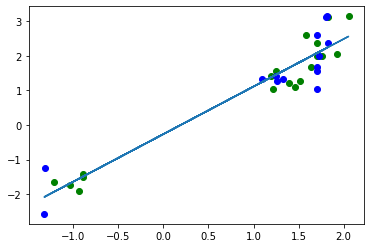

In [15]:
from collections import OrderedDict

OurECM_NIDEPTMT2 = set(TMT2Result[((TMT2Result['group'] == 'tab:red') | (TMT2Result['group'] == 'tab:blue')) & 
                              (TMT2Result['Label'] == "ECM vs NI")]['Protein'])
OurECM_NIDEPTMT2 = set(map(lambda x : x.split('|')[-1], OurECM_NIDEPTMT2))

OurECM_NIDEPTMT1 = set(TMT1Result[((TMT1Result['group'] == 'tab:red') | (TMT1Result['group'] == 'tab:blue')) & 
                              (TMT1Result['Label'] == "ECM vs NI")]['Protein'])
OurECM_NIDEPTMT1 = set(map(lambda x : x.split('|')[-1], OurECM_NIDEPTMT1))

shared1_dep = set(TMT1_diff_Data[TMT1_diff_Data['Mean ratios'] != '/']['ID']).intersection(OurECM_NIDEPTMT1)
shared2_dep = set(TMT2_diff_Data[TMT2_diff_Data['Mean ratios'] != '/']['ID']).intersection(OurECM_NIDEPTMT2)

ot1 = TMT1_diff_Data[(TMT1_diff_Data['Mean ratios'] != '/') & (TMT1_diff_Data['ID'].isin(shared1_dep))][['ID','Mean ratios']]
ot1['log2 Mean ratios'] = ot1.apply(lambda x: np.log2(x['Mean ratios']), axis = 1)
ot2 = TMT2_diff_Data[(TMT2_diff_Data['Mean ratios'] != '/') & (TMT2_diff_Data['ID'].isin(shared2_dep))][['ID','Mean ratios']]
ot2['log2 Mean ratios'] = ot2.apply(lambda x: np.log2(x['Mean ratios']), axis = 1)

ot1dict = OrderedDict(sorted(zip(ot1['ID'], ot1['log2 Mean ratios'])))
ot2dict = OrderedDict(sorted(zip(ot2['ID'], ot2['log2 Mean ratios'])))

TMT1Result['ID'] = TMT1Result.apply(lambda x: x['Protein'].split("|")[-1], axis = 1)
TMT2Result['ID'] = TMT2Result.apply(lambda x: x['Protein'].split("|")[-1], axis = 1)

pt1 = TMT1Result[((TMT1Result['group'] == 'tab:red') | (TMT1Result['group'] == 'tab:blue')) & 
                 (TMT1Result['ID'].isin(shared1_dep)) & (TMT1Result['Label'] == 'ECM vs NI')][['ID','log2FC']]

pt2 = TMT2Result[((TMT2Result['group'] == 'tab:red') | (TMT2Result['group'] == 'tab:blue')) & 
                 (TMT2Result['ID'].isin(shared2_dep)) & (TMT2Result['Label'] == 'ECM vs NI')][['ID','log2FC']]

pt1dict = OrderedDict(sorted(zip(pt1['ID'], pt1['log2FC'])))
pt2dict = OrderedDict(sorted(zip(pt2['ID'], pt2['log2FC'])))

fig = plt.figure()
ax = plt.subplot()
z1 = np.polyfit(list(ot1dict.values()) + list(ot2dict.values()), list(pt1dict.values()) + list(pt2dict.values()), 1)
p1 = np.poly1d(z1)
yvals=p1(list(ot1dict.values()) + list(ot2dict.values()))
ax.plot(list(ot1dict.values()) + list(ot2dict.values()), yvals)

ax.scatter(ot1dict.values(), pt1dict.values(), c='green')
ax.scatter(ot2dict.values(), pt2dict.values(), c='blue')

plt.show()

### HeatMap in the Whole Experiment

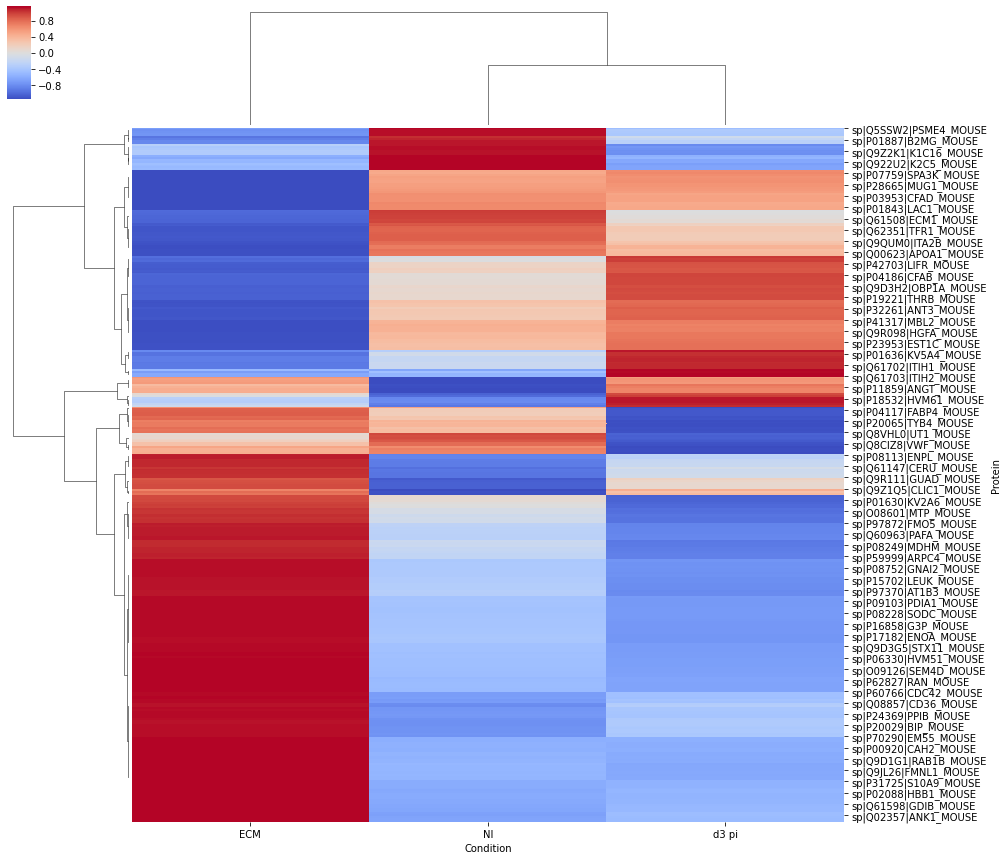

In [80]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
 
# Data set
url = '/home/qinchunyuan/tmt_testdata/PXD003772/analysis/protein_expression.csv'
df = pd.read_csv(url)

df2 = df.pivot_table(index='Protein', columns='Condition', values='Abundance',aggfunc=np.mean)
df2 = df2.dropna()

# plot
g = sns.clustermap(df2, method='average', metric='correlation', z_score=0, figsize=(15,15), xticklabels=True, cmap="coolwarm")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels())#, fontsize = 5)

# tmp = g.ax_heatmap.get_xaxis()

threshold = 0.1
x_labels_ticks = g.ax_heatmap.get_xticklabels()

total_genes_above_threshold = 0
for i, xtickdata in enumerate(x_labels_ticks):
    protein = xtickdata._text
    if df2[protein].max() >= threshold:
        # print(df2[protein])
        # print("#########")
        total_genes_above_threshold = total_genes_above_threshold + 1
        # print(df2[protein].max())
    else:
        xtickdata._text = ''

#print("total_genes_above_threshold {}".format(total_genes_above_threshold))

# re set the tick labels with the modified list
g.ax_heatmap.set_xticklabels(x_labels_ticks)
plt.show()